In [ ]:
!pip install pySPM


In [ ]:
!pip install pint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
from pySPM import Bruker
from scipy import ndimage
from pint import UnitRegistry
import numpy as np
from matplotlib import pyplot as plt
import tqdm
import json


def poly_flatten(data, deg, axis=0):

    fitted_data = np.zeros_like(data)

    major_axis = axis
    minor_axis = int(~bool(major_axis))

    xpos = np.arange(data.shape[minor_axis])
    pbar = tqdm.tqdm(np.arange(data.shape[major_axis]))
    for i in pbar:
        if major_axis == 0:
            this_line = data[i, :]
        else:
            this_line = data[:, i]
        coef = np.polyfit(xpos, this_line, deg)
        offs = np.polyval(coef, xpos)
        if major_axis == 0:
            fitted_data[i, :] = this_line - offs
        else:
            fitted_data[:, i] = this_line - offs

    return fitted_data


def read_and_plot_spm(filename):

    spm = Bruker(filename)
    img = spm.get_channel('Height Sensor')
    img = img.correct_plane().corr_fit2d().filter_scars_removal(inline=False)

    data = np.array(img.pixels.copy())
    data = poly_flatten(data, deg=2)            # leveling
    data = ndimage.median_filter(data, size=2)  # median filter
    data = np.array(data) - np.mean(data)       # zero-average

    ureg = UnitRegistry()
    Q_ = ureg.Quantity

    # compute real dimensions with pint
    base_unit = 'nm'
    pix, _ = [Q_(*it).to(base_unit).magnitude for it in img.pxs()]
    xdim = pix * img.size['pixels']['x']
    ydim = pix * img.size['pixels']['y']  # looks like the metadata is wrong about y scale?
    zdim = Q_(1, img.zscale).to(base_unit).magnitude

    # plot image with some estimate for bounds
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(np.flipud(data), 'bone',
                vmin=np.percentile(data, 0.5), vmax=np.percentile(data, 99.5),
                extent=[0, xdim, 0, ydim])

    ax.set_xlabel(f'x ({base_unit})')  # label axis with units
    ax.set_ylabel(f'y ({base_unit})')

    cb = plt.colorbar(im)
    cb.set_label( base_unit )  # label colorbar with units

    return fig


class SPMRecord(object):

    def __init__(self, filename, channel='Height Sensor', base_unit='nm'):
        suffix = filename.split('.')[-1]
        if suffix == 'json':
            self.load(filename)
            return
        elif suffix != 'spm':
            raise ValueError('Expected json or spm file.')

        spm = Bruker(filename)
        img = spm.get_channel(channel)
        img = img.correct_plane().corr_fit2d().filter_scars_removal(inline=False)

        # compute real dimensions with pint
        ureg = UnitRegistry()
        Q_ = ureg.Quantity

        self.base_unit = base_unit
        pix, _ = [Q_(*it).to(self.base_unit).magnitude for it in img.pxs()]
        self.xdim = pix * img.size['pixels']['x']
        self.ydim = pix * img.size['pixels']['y']  # looks like the metadata is wrong about y scale?
        self.zdim = Q_(1, img.zscale).to(self.base_unit).magnitude

        # retain raw data from spm
        data = np.array(img.pixels.copy())

        # level the image using preset filters
        data = poly_flatten(data, deg=2)            # leveling
        data = ndimage.median_filter(data, size=2)  # median filter
        data = np.array(data) - np.mean(data)       # zero-average

        self.data = data

    def plot(self):
        # plot image with some estimate for bounds
        fig, ax = plt.subplots(figsize=(16, 8))
        im = ax.imshow(np.flipud(self.data), 'bone',
                    vmin=np.percentile(self.data, 0.5),
                    vmax=np.percentile(self.data, 99.5),
                    extent=[0, self.xdim, 0, self.ydim])

        ax.set_xlabel(f'x ({self.base_unit})')  # label axis with units
        ax.set_ylabel(f'y ({self.base_unit})')

        cb = plt.colorbar(im)
        cb.set_label( self.base_unit )  # label colorbar with units

        return fig

    def save(self, filename):
        buffer = {}
        buffer['dimensions'] = {'base_unit': self.base_unit, 'z': self.zdim,
                                'y': self.ydim, 'x': self.xdim}
        buffer['data'] = self.data.round(3).tolist()

        with open(filename, 'w') as fid:
            json.dump(buffer, fid)

        return

    def load(self, filename):
        with open(filename, 'r') as fid:
            buffer = json.load(fid)

        self.data = np.array(buffer['data'])

        dims = buffer['dimensions']
        self.base_unit = dims['base_unit']
        self.xdim = dims['x']
        self.ydim = dims['y']
        self.zdim = dims['z']

        return

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import pandas as pd


#drive_prefix = '/content/drive/MyDrive/First_AFM_Images_Per_SampleLabel_with_Activities/'
drive_prefix ='/content/drive/MyDrive/MoS2_HeightCenter1um_spm_with_Activities/'

all_files = glob.glob(os.path.join( drive_prefix, '*.spm'))
print(f'found {len(all_files)} tif files in Drive')

found 368 tif files in Drive


In [ ]:
import pandas as pd


sampleLabels = []
for item in all_files:
  filename = item.split('/')[-1]
  sampleLabel = filename.split('_')[0]
  if sampleLabel not in sampleLabels:
    sampleLabels.append(sampleLabel)
  #sampleId = filename.split('_')[1]
  #print(sampleLabel)

print(len(sampleLabels))
dict = {'sampleLabel': sampleLabels}

df = pd.DataFrame(dict)

# saving the dataframe
df.to_csv('Quantitative_Analysis_of_Chalcogenide_Thin_Film_Micrographs_with_Machine_Learning.csv')

269


In [ ]:

# what I need for the MoS2 processing
from pySPM import Bruker
import tqdm
from pint import UnitRegistry
import cv2
IMG_SIZE = 224
MoS2_spmImage_ids = {'sampleLabel': [], 'sampleId': [], 'image': []}
spm_numpy = []
for item in all_files:
  filename = item.split('/')[-1]
  sampleLabel = filename.split('_')[0]
  sampleId = filename.split('_')[1]


  spm = Bruker(item)
  img1 = spm.get_channel('Height Sensor').correct_plane().corr_fit2d().filter_scars_removal(inline=False)
  deg = 2
  data = np.array(img1.pixels.copy())
  fitted_data = np.zeros_like(data)
  for major_axis in [0]:
      minor_axis = int(~bool(major_axis))
      xpos = np.arange(data.shape[minor_axis])
      pbar = tqdm.tqdm(np.arange(data.shape[major_axis]))
      for i in pbar:
          if major_axis == 0:
              this_line = data[i, :]
          else:
              this_line = data[:, i]
          coef = np.polyfit(xpos, this_line, deg)
          offs = np.polyval(coef, xpos)
          if major_axis == 0:
              fitted_data[i, :] = this_line - offs
          else:
              fitted_data[:, i] = this_line - offs
      data = np.array(fitted_data)

  data = np.array(data) - np.mean(data)  # zero-average

  filtered_data = ndimage.median_filter(data, size=2)

  low, high = np.percentile(filtered_data, [0.5, 99.5])
  AFM_Images = np.clip(filtered_data, low, high)
  AFM_Images -= AFM_Images.min()
  AFM_Images = AFM_Images / AFM_Images.max() * 255
#  #Images = (AFM_Images).resize((IMG_SIZE, IMG_SIZE))
  image = cv2.resize(AFM_Images, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

  MoS2_spmImage_ids['image'].append(image)
  MoS2_spmImage_ids['sampleLabel'].append(sampleLabel)
  MoS2_spmImage_ids['sampleId'].append(sampleId)

100%|██████████| 512/512 [00:00<00:00, 2955.59it/s]


In [ ]:
import pickle

with open("/content/drive/MyDrive/Time_Series_Files/MoS2_spmImage_ids", "wb") as fp:   #Pickling
  pickle.dump(MoS2_spmImage_ids, fp)

In [ ]:
from google.colab import files

files.download('/content/drive/MyDrive/Time_Series_Files/MoS2_spmImage_ids')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

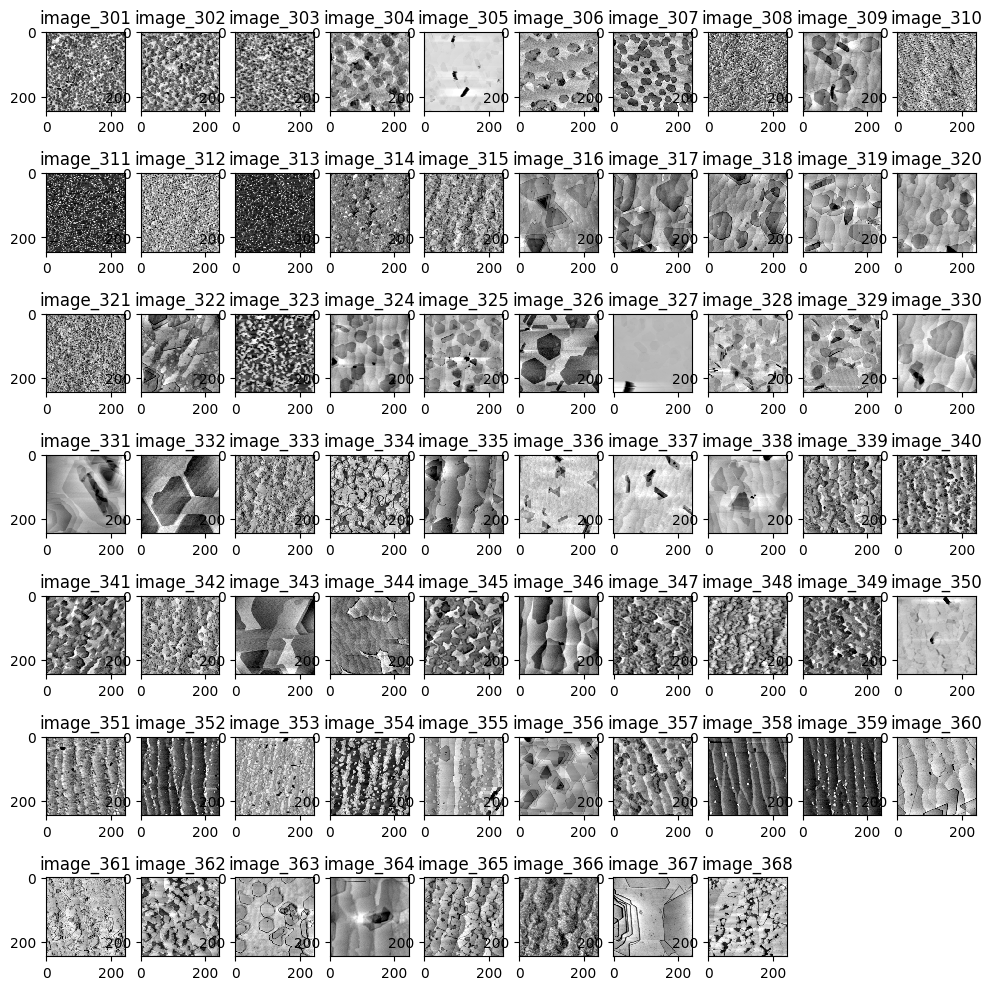

In [ ]:
fig = plt.figure(figsize=(12, 18))  # width, height in inches

for i in range(300, 368):
    #sub = fig.add_subplot(64, 1, i + 1)
    sub = fig.add_subplot(10, 10, i + 1-300)
    sub.imshow(spm_numpy[i], interpolation='nearest',cmap='binary')
    sub.set_title(f'image_{i+1}')